In [5]:
# yunzhe and beatrice generated IsoQuant results from the WTC11 LRGASP data

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *

In [3]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [4]:
ab = od+expand(config['lr']['talon']['ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]

ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]

# pp_summary = '../'+expand(config['data']['p_pred']['summary'], species='human')[0]


iq_gtf = od+expand(config['lr']['isoquant']['gtf'], species='human')[0]
iq_ics = od+expand(config['lr']['isoquant']['cerberus']['ics'], species='human')[0]
iq_ab = od+expand(config['lr']['isoquant']['novel_ab'], species='human')[0]

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'polya'
obs_col = 'sample'
go_gene_subset = 'protein_coding'
predom_iso_subset = 'protein_coding'

m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]

## Venn diagrams of transcripts we detect in IsoQuant+Cerberus vs. TALON+LAPA+Cerberus


## How many transcripts do we detect in WTC11?

In [4]:
# df = pd.read_csv(filt_ab, sep='\t')
# df, tids = get_tpm_table(df, 
#                          how='iso',
#                          min_tpm=1,
#                          gene_subset=None,
#                          sample=['wtc11'])

## Check out WTC11 GTF

In [5]:
# df = pr.read_gtf(isoquant_gtf)
# df.head()

In [6]:
# need to get cerberus version of GTF, abundance file
# need to filter stuff in the same way ie remove unspliced
# unsuppored ISMs


In [7]:
ca = cerberus.read(cerberus_h5)
ca.ic_sources

['gtex', 'v29', 'v40', 'lapa']

In [8]:
# def add_ics(ca,
#                 ic,
#                 ref,
#                 source):
#         """
#         Add features or incorporate them as forms of support to an
#         existing CerberusAnnotation.

#         Parameters:
#             ic (str): IC TSV file path
#             ref (bool): Use regions from IC file as reference regions to define
#                 region novelty
#             source (str): Name of BED source
#         """

#         df = ca.ic.copy(deep=True)
#         sources = ca.ic_sources
#         df['id'] = [i for i in range(len(df.index))]

#         if source in sources:
#             raise Exception(f'IC source {source} already in CerberusAnnotation.')

#         if len(df) > 0:
#             first_add = False
#         else:
#             first_add = True
            
#         temp = cerberus.read_ic_ref(ic)
        
#         # if we're dealing with a new ic file,
#         # update the ic novelty and source name
#         # otherwise, retain the labels already given
#         # in the ics file
#         if source != 'cerberus':
#             temp['source'] = source
#             if ref:
#                 nov = 'Known'
#             else:
#                 nov = 'Novel'
#             temp['novelty'] = nov
        
#         df = cerberus.agg_2_ics(df, temp)

#         # determine ic novelty for novel ics
#         # if source != 'cerberus':
#         df = cerberus.get_ic_novelty(df)

#         # drop gene id and ic number as they are captured in name
#         df.drop(['gene_id', 'ic'], axis=1, inplace=True)
        
#         # update ics in ca
#         ca.ic = df
#         ca.ic_sources.append(source)


In [9]:
# new cerberus function to add ics to an existing thing
ics = pd.read_csv(iq_ics, sep='\t')

In [10]:
add_ics(ca,
                iq_ics,
                False,
                'isoquant_wtc11')

In [11]:
ca.ic_sources

['gtex', 'v29', 'v40', 'lapa', 'isoquant_wtc11']

<AxesSubplot:xlabel='novelty', ylabel='Name'>

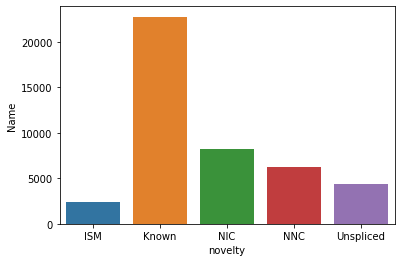

In [17]:
df = ca.ic.loc[ca.ic.source.str.contains('isoquant')].copy(deep=True)
temp = df[['novelty', 'Name']].groupby('novelty').count().reset_index()
sns.barplot(temp, y='Name', x='novelty')

<AxesSubplot:xlabel='novelty', ylabel='Name'>

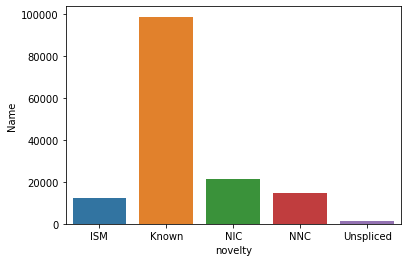

In [18]:
df = ca.ic.loc[ca.ic.source.str.contains('lapa')].copy(deep=True)
temp = df[['novelty', 'Name']].groupby('novelty').count().reset_index()
sns.barplot(temp, y='Name', x='novelty')

## Format IsoQuant abundance file

In [20]:
def format_isoquant_ab(ab, dataset, lib_meta, ofile):
    """
    Format abundance file from isoquant GFF into a format
    that Cerberus can deal with
    """
    meta = pd.read_csv(lib_meta, sep='\t')
    df = pd.read_csv(ab, sep='\t')
    df.head()
    df['annot_transcript_id'] = df['#feature_id']
    df['annot_transcript_name'] = df['annot_transcript_id']
    df['transcript_ID'] = df['annot_transcript_id']
    df.columns = [c.split('.')[0] for c in df.columns]
    df.drop('#feature_id', axis=1, inplace=True)
    m = dict([(entry['ENCODE_alignments_id'], entry['dataset']) for ind, entry in meta[['dataset', 'ENCODE_alignments_id']].iterrows()])
    df.columns = [m[c] if 'ENCFF' in c else c for c in df.columns]
    
    df.to_csv(ofile, sep='\t', index=False)

In [48]:

df.head()


,wtc11_1_1,wtc11_1_3,wtc11_1_2,annot_transcript_id,annot_transcript_name,transcript_ID
0,5.016551,4.130977,10.360410,ENST00000003583.12,ENST00000003583.12,ENST00000003583.12
1,2.315331,1.652391,6.906940,ENST00000003912.7,ENST00000003912.7,ENST00000003912.7
2,27.012200,16.523907,12.662723,ENST00000040877.1,ENST00000040877.1,ENST00000040877.1
3,12.348434,12.117532,18.418507,ENST00000054650.8,ENST00000054650.8,ENST00000054650.8
4,50.165515,40.758970,56.406677,ENST00000054666.10,ENST00000054666.10,ENST00000054666.10


In [34]:
meta = pd.read_csv(lib_meta, sep='\t')
meta.head()

,ENCODE_experiment_id,dataset,sample,sample_display,general_tissue_cell_type,fig1_tissue_label,health_status,tissue_or_cell_line,sample_color_hex_code,matching_mouse_samples,reads_post_talon,ENCODE_alignments_id,ENCODE_reads_id,ENCODE_unfiltered_alignments_id,document_urls,document_labels,platform,RIN,spikeins
0,ENCSR989ZYL,a673_1_1,a673,A673,a673,bone,NaN,cell_line,#de3700,NaN,1330194,ENCFF045ZQI,ENCFF168MIB,ENCFF440LXJ,https://www.encodeproject.org/documents/6d583a...,'ENCODE Long Read RNA-Seq Analysis Protocol fo...,Pacific Biosciences Sequel II,9.8,True
1,ENCSR989ZYL,a673_1_2,a673,A673,a673,bone,NaN,cell_line,#de3700,NaN,1707207,ENCFF320GCF,ENCFF861BKY,ENCFF240FZT,https://www.encodeproject.org/documents/6d583a...,'ENCODE Long Read RNA-Seq Analysis Protocol fo...,Pacific Biosciences Sequel II,9.8,True
2,ENCSR081NRO,adrenal_gland_1_1,adrenal_gland,Adrenal gland,adrenal gland,adrenal gland,NaN,tissue,#e69b00,"adrenal_gland,adrenal_10d,adrenal_14d,adrenal_...",765655,ENCFF147OYL,ENCFF211SQY,ENCFF967OHL,https://www.encodeproject.org/documents/54012f...,'non-size selected cDNA libraries for use in P...,Pacific Biosciences Sequel,9.8,False
3,ENCSR563RLX,adrenal_gland_2_1,adrenal_gland,Adrenal gland,adrenal gland,adrenal gland,NaN,tissue,#e69b00,"adrenal_gland,adrenal_10d,adrenal_14d,adrenal_...",1579294,ENCFF791WUV,ENCFF417ALN,ENCFF900XHI,https://www.encodeproject.org/documents/3baa46...,"'PacBio libraries v3 (October, 2020) Protocol ...",Pacific Biosciences Sequel II,NaN,True
4,ENCSR995WKW,adrenal_gland_3_1,adrenal_gland,Adrenal gland,adrenal gland,adrenal gland,NaN,tissue,#e69b00,"adrenal_gland,adrenal_10d,adrenal_14d,adrenal_...",577077,ENCFF243PFI,ENCFF912HPY,ENCFF020MWV,https://www.encodeproject.org/documents/54012f...,'non-size selected cDNA libraries for use in P...,Pacific Biosciences Sequel,9.4,False
